In [1]:
import sys
sys.path.append('../..')

import numpy as np
from numpy.matlib import repmat
import pandas as pd
import eeg_decoder as eeg_decoder
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

from mne.filter import filter_data
from scipy.signal import hilbert, chirp

from collections import Counter
%load_ext autoreload
%autoreload 2

C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
exp.behavior_files = sorted(list(exp.data_dir.glob('*behavior.csv')))

In [3]:
tois = np.arange(-200, 1001, 2)
times_bool = [1 if (t in tois) else 0 for t in exp.info['times']]
censor_times = exp.info['times'] > 1000 # values to convert to 0 to prevent leak backwards

In [4]:
time_window = 25
time_step = 25
trial_bin_size = 1 # not used
n_splits = 25
group_dict = {}

wrangl = eeg_decoder.Wrangler(tois,time_window,time_step,trial_bin_size,n_splits,group_dict)
wrangl.t

array([-200, -176, -152, -128, -104,  -80,  -56,  -32,   -8,   16,   40,
         64,   88,  112,  136,  160,  184,  208,  232,  256,  280,  304,
        328,  352,  376,  400,  424,  448,  472,  496,  520,  544,  568,
        592,  616,  640,  664,  688,  712,  736,  760,  784,  808,  832,
        856,  880,  904,  928,  952,  976])

In [5]:
palette = {
    'N1': 'royalblue',
    'H1': 'forestgreen',
    'L1': 'coral',
    '2': 'maroon'
}

# Helpers

In [6]:
def makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx):
    assert len(Cond1Idx)==len(Cond2Idx) and len(posLabels)==len(Cond1Idx)
    
    nTrials = len(Cond1Idx); 
    blocks = np.full((nTrials), np.nan)
    
    C1_posLabels = posLabels[Cond1Idx]
    C2_posLabels = posLabels[Cond2Idx]
    
    binCnt = np.full((2, nBins), np.nan)
    for b in range(nBins):
        binCnt[0,b] = np.sum(C1_posLabels == b+1)
        binCnt[1,b] = np.sum(C2_posLabels == b+1)

    minCnt = np.min(binCnt)
    nPerBin = int(np.floor(minCnt/nBlocks))
    
    
    for c in [1, 2]:
        pBin = C1_posLabels if c==1 else C2_posLabels

        tmp_nTrials = len(pBin)
        shuffBlocks = np.full(pBin.shape, np.nan)

        # shuffle trials
        shuffInd = np.arange(tmp_nTrials)
        np.random.shuffle(shuffInd)
        shuffBin = pBin[shuffInd] # shuffle trial order

        # take the 1st nPerBin x nBlocks trials for each position bin.
        for b in range(nBins):
            idx = np.where(shuffBin == b+1)[0]  # get index for trials belonging to the current bin
            idx = idx[:nPerBin*nBlocks]  # drop excess trials
            x = repmat(np.arange(1, nBlocks+1), 1, nPerBin)
            shuffBlocks[idx] = x # assign trials to blocks

        if c==1:
            C1_Blocks = np.full(C1_posLabels.shape, np.nan)
            C1_Blocks[shuffInd] = shuffBlocks
        elif c==2:
            C2_Blocks = np.full(C2_posLabels.shape, np.nan)
            C2_Blocks[shuffInd] = shuffBlocks


    ## regular blocks is just two condLabels combined
    blocks[Cond1Idx] = C1_Blocks
    blocks[Cond2Idx] = C2_Blocks
    nTrialsPerBlock = np.sum(blocks==1) # of trials per block
    nTrialsPerBlock_C1 = np.sum(blocks[Cond1Idx]==1)
    nTrialsPerBlock_C2 = np.sum(blocks[Cond2Idx]==1)
    
    return(blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2)

In [7]:
def MakeCircularBasis_Even_Bins(nBins, nChans, sinPower, x):
    prediction = np.sin(0.5*x)**sinPower
    prediction = np.roll(prediction, 4, axis=0)
    basisSet = np.full((nChans, nBins), np.nan)
    basisSet[0, :] = prediction
    for c in range(1, nChans):
        basisSet[c, :] = prediction = np.roll(prediction, 1, axis=0)
    return(basisSet)

In [8]:
def MakeDeltaBasis_Square(nBins, nChans):
    
    assert nBins==nChans # for this sudy, we are using 4 and 4
    return(np.eye(nBins, nChans))
    

In [9]:
def sort_and_mean_CTF(ctf, shuffle=False): 
    # these are the quadrants
    #########
    # 0 # 1 #
    #########
    # 3 # 2 #
    #########
    # the channels for each bin get resorted to be 0=bin, 1=adjacent same hemi, 2=adjacent cross hemi, 3=diagonal
    
    bin_idx = [0, 1, 2, 3]
    if shuffle:
        bin_idx = np.random.permutation(bin_idx) # shuffle how each bin is treated

    ctf[bin_idx[0], :] = ctf[bin_idx[0], [0, 3, 1, 2]]
    ctf[bin_idx[1], :] = ctf[bin_idx[1], [1, 2, 0, 3]]
    ctf[bin_idx[2], :] = ctf[bin_idx[2], [2, 1, 3, 0]]
    ctf[bin_idx[3], :] = ctf[bin_idx[3], [3, 0, 2, 1]]
    
    return np.mean(ctf, 0) # mean across bins

def CTF_Slope(ctf):
    x = [1, 2, 3]
    y = [ctf[0], ctf[[1,2]].mean(), ctf[3]]
    return(np.polyfit(x, y, deg=1)[0]) # fit and get slope

In [10]:
def IEM_2cond(totalPower, posLabels, condLabels, times_bool, sinPower=25, nBins=4, nChans=4, nIter=25, nBlocks=3, freq_bounds=[8, 12], time = tois, Fs=500, wrangl=wrangl):
    # ARGUMENTS
    # totalPower = alpha power of EEG data of shape nTrials, nElectrodes, nTimePoints
    # posLabels = list of spatial positions (in terms of bin number) for each trial
    # condLabels = list of condition labels (1 or 2) for each trial
    # sinPower = power of the response function 
    # nBins = num location bins
    # nChans = num channels (cell popluations)
    # nIter =  num iterations (input to function)
    # nBlocks = num blocks for cross-validation
    # freq_bounds = frequency range to analyze 
    # nSamps = num time points of interest
    # Fs = Sampling rate of EEG

    nSamps = len(time)
    nTrials = len(posLabels)
    nElectrodes = totalPower.shape[1]
    
    x = np.linspace(0, 2*np.pi-2*np.pi/nBins, nBins)
    basisSet = MakeDeltaBasis_Square(nBins, nChans)
    
    Cond1Idx = condLabels==1
    Cond2Idx = condLabels==2
    
    # Preallocate Output Matrices
    tf_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    tf_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks,nChans), np.nan)
    
    sl_total_Cond1 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2 = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond1_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    sl_total_Cond2_shuff = np.full((nIter,len(wrangl.t),nBlocks), np.nan)
    
    blocks = np.full((nTrials,nIter), np.nan)
    
    ## Filter and Organize Data into Blocks
    totalPower = np.squeeze(totalPower[:, :, np.where(times_bool)]) # subset to times-of-interest
    assert totalPower.shape[2]==nSamps
    
    ## create block assignments
    for i in range(nIter):
        (curr_blocks, nTrialsPerBlock, nTrialsPerBlock_C1, nTrialsPerBlock_C2) = makeBlockAssignment_CommonTrain(nBlocks,nBins,posLabels,Cond1Idx,Cond2Idx);
        blocks[:,i] = curr_blocks
        
    tmpBlocks = blocks.copy()
    
    for i in range(nIter):
        curr_blocks = tmpBlocks[:,i]
        
        # Preallocate
        blockDat_total = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond1 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)
        blockDat_total_Cond2 = np.full((nBins*nBlocks, nElectrodes, nSamps), np.nan)

        labels = np.full((nBins*nBlocks), np.nan)
        blockNum = np.full((nBins*nBlocks), np.nan)
        c = np.full((nBins*nBlocks, nChans), np.nan)

        # Average data for each bin across blocks
        counter = 0
        for j in range(nBins):
            for k in range(nBlocks):
                # all data for training
                blockDat_total[counter,:,:] = np.mean(totalPower[(posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond1 Test
                blockDat_total_Cond1[counter,:,:] = np.mean(totalPower[(Cond1Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)
                # Cond2 Test
                blockDat_total_Cond2[counter,:,:] = np.mean(totalPower[(Cond2Idx) & (posLabels==j+1) & (curr_blocks==(k+1)),:,:],0)

                # info
                labels[counter] = j
                blockNum[counter] = k
                c[counter,:] = basisSet[j,:]
                counter+=1

        # run IEM on each timepoint
        for t in range(len(wrangl.t)):
            time_window_idx = (wrangl.samples >= wrangl.t[t]) & (
                wrangl.samples < wrangl.t[t] + wrangl.time_window)
            
            dt = np.mean(blockDat_total[:, :, time_window_idx], 2)
            dt_Cond1 = np.mean(blockDat_total_Cond1[:,:,time_window_idx], 2)
            dt_Cond2 = np.mean(blockDat_total_Cond2[:,:,time_window_idx], 2)

            for b in range(nBlocks): # hold out each block as the test set, train on the other 2
                train_labels = labels[blockNum!=b]
                test_labels = labels[blockNum==b]

                C1 = c[blockNum!=b, :]
                B1 = dt[blockNum!=b, :]
                B2_Cond1 = dt_Cond1[blockNum==b, :]
                B2_Cond2 = dt_Cond2[blockNum==b, :]

                # fit model and record res
                channel_weights = np.linalg.lstsq(C1, B1, rcond=None)[0]
                
                recon1 = np.linalg.lstsq(channel_weights.T , B2_Cond1.T, rcond=None)[0].T
                CTF_C1 = sort_and_mean_CTF(recon1);
                CTF_C1_shuff = sort_and_mean_CTF(recon1, shuffle=True)
                
                recon2 = np.linalg.lstsq(channel_weights.T , B2_Cond2.T, rcond=None)[0].T
                CTF_C2 = sort_and_mean_CTF(recon2);
                CTF_C2_shuff = sort_and_mean_CTF(recon2, shuffle=True)
                
                
                # record CTFs
                tf_total_Cond1[i,t,b,:] = CTF_C1
                tf_total_Cond1_shuff[i,t,b,:] = CTF_C1_shuff
                tf_total_Cond2[i,t,b,:] = CTF_C2
                tf_total_Cond2_shuff[i,t,b,:] = CTF_C2_shuff
                
                # record slopes
                sl_total_Cond1[i,t,b] = CTF_Slope(CTF_C1)
                sl_total_Cond1_shuff[i,t,b] = CTF_Slope(CTF_C1_shuff)
                sl_total_Cond2[i,t,b] = CTF_Slope(CTF_C2)
                sl_total_Cond2_shuff[i,t,b] = CTF_Slope(CTF_C2_shuff)

                
    return {
        'CTFs': {
            'Cond1': tf_total_Cond1,
            'Cond1_shuff': tf_total_Cond1_shuff,
            'Cond2': tf_total_Cond2,
            'Cond2_shuff': tf_total_Cond2_shuff,
        },
        'slopes': {
            'Cond1': sl_total_Cond1,
            'Cond1_shuff': sl_total_Cond1_shuff,
            'Cond2': sl_total_Cond2,
            'Cond2_shuff': sl_total_Cond2_shuff,
        }
    }

# setup and clean up data

In [11]:
def get_second_bin(bin_str):
    try:
        return int(bin_str[4])
    except:
        return np.nan

In [12]:
xdata_dict = {}
behavior_dict = {}

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata[:,:,censor_times] = 0 # censor timepoints to prevent bleeding backwards

    noArt_idx = exp.load_artifact_idx(isub)
    assert xdata.shape[0]==noArt_idx.sum()

    behavior = pd.read_csv(exp.behavior_files[isub])
    behavior = behavior[behavior.Block.notnull()] # cut out original post-task stuff
    
    if len(behavior)!=noArt_idx.shape[0]:
        print(f'error on isub {isub}; won\'t be included')
        continue
        
    behavior = behavior.loc[noArt_idx, :].reset_index(drop=True)
    assert len(behavior)==xdata.shape[0]

    behavior['Bin'] = behavior.Quadrants.apply(lambda x: int(x[1])).values
    behavior['OtherBin'] = behavior.Quadrants.apply(get_second_bin).values
    
    xdata_dict[isub] = np.abs(hilbert(filter_data(xdata.astype(np.float64), 500, 8, 12)))**2 # convert to total alpha power
    behavior_dict[isub] = behavior

0
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 sec)

1
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)


In [13]:
def make_CTF_df(results_dict, isub, cond, condname, wrangl=wrangl, t=200):
    sub_CTFs = pd.DataFrame()
    # mean across iterations, blocks, ignore the first 500ms before meaning across time
    sub_CTFs['Response'] = results_dict[isub]['CTFs'][cond].mean(0).mean(1)[wrangl.t > t, :].mean(0)
    sub_CTFs['Channel'] = np.arange(1,5)
    sub_CTFs['PID'] = isub
    sub_CTFs['condition'] = condname
    return(sub_CTFs)

In [14]:
def make_slope_df(results, isub, cond, condname, time=wrangl.t):
    sub_slopes = pd.DataFrame()
    sub_slopes['time'] = time
    sub_slopes['Slope'] = results[isub]['slopes'][cond].mean(0).mean(1)
    sub_slopes['PID'] = isub
    sub_slopes['condition'] = condname
    return(sub_slopes)

## Pipeline

In [15]:
sns.set_theme(font_scale=1.5,style='white')
plt.subplots(figsize=(8,6))
palette = ['forestgreen', 'orange']

In [16]:
def compare_two_conds(low, high, xdata_dict=xdata_dict, behavior_dift=behavior_dict, bin_col='Bin'):
    cond_map = {
        low: 1,
        high: 2
    }
    
    IEM_results = {}

    for isub in xdata_dict:
        xdata = xdata_dict[isub]
        behavior = behavior_dict[isub]

        subset_idx = behavior.BlockCondition.isin([low, high])

        xdata = xdata[subset_idx]
        posLabels = behavior.loc[subset_idx, bin_col].values + 1 # shift from 0-3 to 1-4
        condLabels = behavior.loc[subset_idx, 'BlockCondition'].values

        condLabels = np.array(list(map(cond_map.get, condLabels))) # convert to 1s and 2s

        print(isub, Counter(condLabels))

        IEM_results[isub] = IEM_2cond(xdata, posLabels, condLabels, times_bool)
        
    # plot slope results
    slope_df = pd.DataFrame()
    for isub in IEM_results:
        sub_slopes_obs = pd.concat([make_slope_df(IEM_results, isub, 'Cond1', low),
               make_slope_df(IEM_results, isub, 'Cond2', high)])
        sub_slopes_obs['method'] = 'Observed'

        sub_slopes_shuff = pd.concat([make_slope_df(IEM_results, isub, 'Cond1_shuff', low),
               make_slope_df(IEM_results, isub, 'Cond2_shuff', high)])
        sub_slopes_shuff['method'] = 'Shuffled'

        slope_df = pd.concat([slope_df, sub_slopes_obs, sub_slopes_shuff])

    slope_df = slope_df.reset_index(drop=True)
    
    # _ = sns.lineplot(x='time', y='Slope', hue='condition', style='method', data=slope_df, palette=palette)
    # _ = plt.axhline(y=0, color='k', linestyle='--', linewidth=3)
    # plt.show()
    # plt.close()
    
    # plot CTF reconstructed 
    CTF_df = pd.DataFrame()
    for isub in IEM_results:
        sub_CTFs_obs = pd.concat([make_CTF_df(IEM_results, isub, 'Cond1', low),
               make_CTF_df(IEM_results, isub, 'Cond2', high)])
        sub_CTFs_obs['method'] = 'Observed'

        sub_CTFs_shuff = pd.concat([make_CTF_df(IEM_results, isub, 'Cond1_shuff', low),
               make_CTF_df(IEM_results, isub, 'Cond2_shuff', high)])
        sub_CTFs_shuff['method'] = 'Shuffled'


        CTF_df = pd.concat([CTF_df, sub_CTFs_obs, sub_CTFs_shuff])

    CTF_df = CTF_df.reset_index(drop=True)

    return CTF_df,slope_df

# Tracing Selectivity of Distractors

In [17]:
_,slope_h12 = compare_two_conds('H1', '2', bin_col='OtherBin')

0 Counter({1: 283, 2: 282})
1 Counter({2: 266, 1: 242})
2 Counter({1: 227, 2: 189})
3 Counter({2: 195, 1: 191})
4 Counter({2: 265, 1: 222})
5 Counter({1: 268, 2: 257})
6 Counter({1: 243, 2: 243})
7 Counter({2: 225, 1: 205})
8 Counter({2: 274, 1: 251})
9 Counter({1: 232, 2: 211})
10 Counter({1: 260, 2: 226})
11 Counter({1: 274, 2: 273})
12 Counter({1: 228, 2: 224})
13 Counter({1: 252, 2: 248})
14 Counter({1: 237, 2: 233})
15 Counter({2: 273, 1: 263})
16 Counter({2: 288, 1: 286})
17 Counter({1: 203, 2: 165})
18 Counter({2: 229, 1: 211})
19 Counter({2: 231, 1: 204})
20 Counter({2: 229, 1: 195})
21 Counter({2: 248, 1: 243})


In [21]:
_,slope_l12 = compare_two_conds('L1', '2', bin_col='OtherBin')

0 Counter({2: 282, 1: 277})
1 Counter({1: 278, 2: 266})
2 Counter({1: 207, 2: 189})
3 Counter({1: 199, 2: 195})
4 Counter({2: 265, 1: 206})
5 Counter({1: 299, 2: 257})
6 Counter({1: 268, 2: 243})
7 Counter({1: 235, 2: 225})
8 Counter({2: 274, 1: 250})
9 Counter({1: 233, 2: 211})
10 Counter({1: 260, 2: 226})
11 Counter({1: 276, 2: 273})
12 Counter({1: 226, 2: 224})
13 Counter({1: 252, 2: 248})
14 Counter({1: 248, 2: 233})
15 Counter({2: 273, 1: 258})
16 Counter({2: 288, 1: 284})
17 Counter({1: 174, 2: 165})
18 Counter({1: 235, 2: 229})
19 Counter({2: 231, 1: 224})
20 Counter({2: 229, 1: 223})
21 Counter({2: 248, 1: 237})


In [22]:
df = pd.concat([slope_h12,slope_l12.query('condition=="L1"')])

In [23]:
df.query('method=="Observed"')

,time,Slope,PID,condition,method
0,-200,-0.021395,0,H1,Observed
1,-176,-0.047468,0,H1,Observed
2,-152,-0.261994,0,H1,Observed
3,-128,-0.339743,0,H1,Observed
4,-104,-0.267160,0,H1,Observed
...,...,...,...,...,...
4245,880,0.108720,21,L1,Observed
4246,904,0.116115,21,L1,Observed
4247,928,-0.000942,21,L1,Observed
4248,952,-0.115693,21,L1,Observed


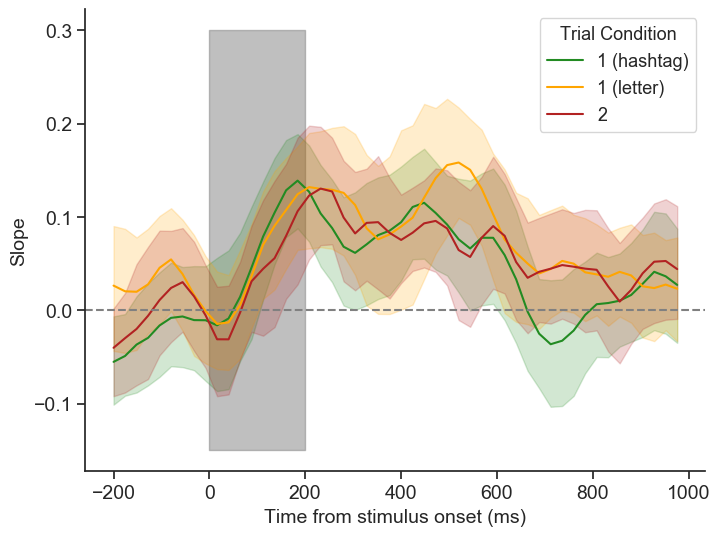

In [24]:
plt.close()
colors = ['forestgreen', 'orange','firebrick']

sd = df.query('method=="Observed"').reset_index()
sd['Slope'] *= -1

fig,ax =plt.subplots(figsize=(8,6))
stim_lower = -.15
stim_upper = .3 
ax.fill_between([0,200], [stim_lower, stim_lower], [
                stim_upper, stim_upper], color='gray', alpha=.5)
ax = sns.lineplot(x='time', y='Slope', hue='condition',  data=sd, palette=colors,hue_order=['H1','L1','2'])
ax.axhline(y=0, color='grey', linestyle='--')

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time from stimulus onset (ms)',fontsize=14)
ax.set_ylabel('Slope',fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
leg = ax.legend(title='Trial Condition',labels=['1 (hashtag)','1 (letter)','2'],fontsize=13)
# leg = ax.legend(title='Trial Condition',labels=['2'],fontsize=13)
plt.setp(leg.get_title(),fontsize=13)
# plt.savefig('slope_1h1l2_distractor.png',dpi=500,bbox_inches='tight')
plt.show()

# Unused from here on
# proportions of distractor/2nd target locations for each participant

In [35]:
    
distractor_mapping = {
    0: {0: 'Target-Quad', 3: 'Adj-Same', 1: 'Adj-Cross', 2: 'Diagonal'},
    1: {1: 'Target-Quad', 2: 'Adj-Same', 0: 'Adj-Cross', 3: 'Diagonal'},
    2: {2: 'Target-Quad', 1: 'Adj-Same', 3: 'Adj-Cross', 0: 'Diagonal'},
    3: {3: 'Target-Quad', 0: 'Adj-Same', 2: 'Adj-Cross', 1: 'Diagonal'},
}

def get_distractor_cond(target_bin, distractor_bin):
    if np.isnan(distractor_bin) or np.isnan(target_bin):
        return None
    else:
        return distractor_mapping[target_bin][distractor_bin]

In [36]:
prop_dict = {
    'isub': [],
    'block_condition': [],
    'distractor_condition': [],
    'proportion': []
}

for isub in behavior_dict:
    behavior = behavior_dict[isub]
    behavior['distractor_condition'] = behavior.apply(lambda x: get_distractor_cond(x.Bin, x.OtherBin), axis=1)

    for cond in ['H1', 'L1', '2']:
        cond_df = behavior.query(f'BlockCondition=="{cond}"').copy()

        distractor_counts = pd.DataFrame(cond_df['distractor_condition'].value_counts())
        distractor_props = distractor_counts / distractor_counts.sum()

        for d_type in ['Adj-Same', 'Adj-Cross', 'Diagonal']:

            prop_dict['isub'].append(isub)
            prop_dict['block_condition'].append(cond)
            prop_dict['distractor_condition'].append(d_type)
            prop_dict['proportion'].append(distractor_props.loc[d_type, 'distractor_condition'])

In [37]:
distractor_proportions = pd.DataFrame(prop_dict)

g = sns.catplot(
    data=distractor_proportions, kind="bar",
    x="distractor_condition", y="proportion", hue="block_condition", alpha=.6,
    palette=palette
)
g.despine(left=True)
_ = g.set(ylim=[.32, .348])

In [38]:
compare_two_conds('L1', '2', bin_col='OtherBin')

0 Counter({2: 282, 1: 277})
1 Counter({1: 278, 2: 266})
2 Counter({1: 207, 2: 189})
3 Counter({1: 199, 2: 195})
4 Counter({2: 265, 1: 206})
5 Counter({1: 299, 2: 257})
7 Counter({1: 268, 2: 243})
8 Counter({1: 235, 2: 225})
9 Counter({2: 274, 1: 250})
10 Counter({1: 233, 2: 211})
11 Counter({1: 260, 2: 226})
12 Counter({1: 276, 2: 273})
13 Counter({1: 226, 2: 224})
14 Counter({1: 252, 2: 248})
15 Counter({1: 248, 2: 233})
16 Counter({2: 273, 1: 258})
17 Counter({2: 288, 1: 284})
18 Counter({1: 174, 2: 165})
19 Counter({1: 235, 2: 229})
20 Counter({2: 231, 1: 224})
21 Counter({2: 229, 1: 223})
22 Counter({2: 248, 1: 237})


(     Response  Channel  PID condition    method
 0    0.532706        1    0        L1  Observed
 1    0.089261        2    0        L1  Observed
 2    0.270250        3    0        L1  Observed
 3    0.144002        4    0        L1  Observed
 4    0.483899        1    0         2  Observed
 ..        ...      ...  ...       ...       ...
 347  0.232013        4   22        L1  Shuffled
 348  0.275626        1   22         2  Shuffled
 349  0.261630        2   22         2  Shuffled
 350  0.264199        3   22         2  Shuffled
 351  0.283976        4   22         2  Shuffled
 
 [352 rows x 5 columns],
       time     Slope  PID condition    method
 0     -200 -0.074619    0        L1  Observed
 1     -176 -0.103966    0        L1  Observed
 2     -152 -0.184718    0        L1  Observed
 3     -128 -0.217894    0        L1  Observed
 4     -104 -0.225103    0        L1  Observed
 ...    ...       ...  ...       ...       ...
 4395   880  0.020905   22         2  Shuffled
 4396   9

# looking at how targets are distributed relative to distractors

In [39]:
prop_dict = {
    'isub': [],
    'block_condition': [],
    'target_condition': [],
    'proportion': []
}

for isub in behavior_dict:
    behavior = behavior_dict[isub]
    behavior['target_condition'] = behavior.apply(lambda x: get_distractor_cond(x.OtherBin, x.Bin), axis=1)

    for cond in ['H1', 'L1', '2']:
        cond_df = behavior.query(f'BlockCondition=="{cond}"').copy()

        distractor_counts = pd.DataFrame(cond_df['target_condition'].value_counts())
        distractor_props = distractor_counts / distractor_counts.sum()

        for d_type in ['Adj-Same', 'Adj-Cross', 'Diagonal']:

            prop_dict['isub'].append(isub)
            prop_dict['block_condition'].append(cond)
            prop_dict['target_condition'].append(d_type)
            prop_dict['proportion'].append(distractor_props.loc[d_type, 'target_condition'])

In [40]:
distractor_proportions = pd.DataFrame(prop_dict)

g = sns.catplot(
    data=distractor_proportions, kind="bar",
    x="target_condition", y="proportion", hue="block_condition", alpha=.6,
    palette=palette
)
g.despine(left=True)
_ = g.set(ylim=[.32, .348])